Experiment Tracking is very important and integral to Machine Learning.

It basically helps one figuring out what works and what doesn't if running lots of different experiments.

### 0. Getting setup

In [1]:
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine

C:\Users\ritis\Desktop\PyTorch-Learning\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Outside of educational or experimental setting, random seeds generally aren't required.
# However, lets functionalize the setting of random seeds since have been setting them up a bunch of times.

def set_seeds(seed: int = 42):
    """Args:
        seed (int, optional): Random seed to set. Default value is 42.
    """
    # CPU seed
    torch.manual_seed(seed)
    # GPU seed
    torch.cuda.manual_seed(seed)

### 1. Get data

In [5]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str, destination: str, remove_source: bool = True) -> Path:
    """Downloads zipped dataset from source and unzips to destination.
    Args:
        source, destination: self explainatory (url, path)
        remove_source: whether to delete the dataset downloaded source after extraction
    Returns: Path to the downloaded data
    """
    # data folder path setup
    data_path = Path("data/")
    image_path = data_path / destination

    # If image folder exists, skip or create and prepare it, otherwise.
    if image_path.is_dir():
        print(f"{image_path} exists, skipped.")
    else:
        print(f"Creating {image_path}")
        image_path.mkdir(parents = True, exist_ok = True)

        # Download the dataset
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print("Downloading dataset...")
            f.write(request.content)

        # Unzip the dataset
        with zipfile.ZipFile(data_path / target_file, "r") as zipf:
            print("Extracting...")
            zipf.extractall(image_path)
        
        # Remove the dataset source, .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

Creating data\pizza_steak_sushi
Extracting...


WindowsPath('data/pizza_steak_sushi')

### 2. Create Datasets and DataLoaders

Since Transfer Learning will be used, images need to be in the same format as the training data images fed into the pretrained model.

Therefore, need to create model-specific transforms to be performed over the data for transfer learning, both manually and automatically.

#### 2.1 Create DataLoaders using manually created transforms

In [6]:
# train and test data directories setup
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup tranform manually w.r.t the ImageNet normalization levels as all torchvision.models are trained on it
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

# Manual creation of the transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manual transforms: {manual_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, manual_transforms, batch_size=32)

train_dataloader, test_dataloader, class_names

Manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x18637f31b10>,
 ['pizza', 'steak', 'sushi'])

#### 2.2 Create DataLoaders using automatically created transforms

In [7]:
# Dirs setup
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms pipeline automatically from weights
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, automatic_transforms, 32)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x18637ffa5d0>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [8]:
# Download pretrained weights for the chosen pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup pretrained model with the weights and send it to target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Freeze the base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# New layer setup because of changing classsifier head (torch.nn.Linear)
# Thus, setting seeds
set_seeds()

# Update the classifier head w.r.t the problem at hand
model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias = True)
).to(device)

Base layers frozen. Classifier head changed. Everything is in place now. Lets get a summary of the model.

In [10]:
summary(model, input_size=(32, 3, 224, 224), verbose = 0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 4. Train model and track results

In [11]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)

In [12]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("TensorBoard not installed...installing it.")
    !conda install tensorboard
    from torch.utils.tensorboard import SummaryWriter

# Create a writer with all the default settings
writer = SummaryWriter()

We'll adjust the existing train() function in the engine.py file to let it use the writer as well.
Specifically, adding the ability for the train() function to log the model's training and testing loss & accuracy values. 

It is important to close the writer using writer.close() to tell it to stop looking for values to track.

Also, the model information can be tracked almost anywhere in the code. But quite often experiments will be tracked while a model is training (inside train/test loop).

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step

# Modifying the existing train function to use the writer instance
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Args:
        All are self-explainatory.

    Returns:
        A dict of train and test loss as well as train and test accuracy metrics.
        Each metric has a value in a list for each epoch.
    """

    # Create an empty results dictionary
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []
              }

    # Loop through train and test steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, dataloader =  train_dataloader, optimizer = optimizer, loss_fn = loss_fn, device = device)
        test_loss, test_acc = test_step(model = model, dataloader = test_dataloader, loss_fn = loss_fn, device = device)

        # Print the stats
        print(f"Epoch: {epoch + 1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")
    
        # Update the results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### Experiment tracking using SummaryWriter ###
        # Add loss results to writer
        writer.add_scalars(main_tag = "Loss",
                           tag_scalar_dict={"train_loss" : train_loss, "test_loss" : test_loss}, global_step=epoch)

        # Add accuracy results to writer
        writer.add_scalars(main_tag = "Accuracy", tag_scalar_dict={"train_acc" : train_acc, "test_acc" : test_acc}, global_step=epoch)

        # Track PyTorch model architecture
        writer.add_graph(model = model, input_to_model=torch.randn(32, 3, 224, 224).to(device)) # Pass an example input

    # Close the writer
    writer.close()
    ### End experiment tracking ###

    return results

In [14]:
# Training the model for trial purposes for 5 epochs
set_seeds()
results = train(model = model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs = 5, device = device)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.3750 | test_loss: 0.9135 | test_acc: 0.5502


 20%|████████████████▊                                                                   | 1/5 [00:52<03:30, 52.51s/it]

Epoch: 2 | train_loss: 0.9017 | train_acc: 0.6484 | test_loss: 0.7943 | test_acc: 0.8258


 40%|█████████████████████████████████▌                                                  | 2/5 [02:35<04:06, 82.02s/it]

Epoch: 3 | train_loss: 0.8139 | train_acc: 0.7266 | test_loss: 0.6804 | test_acc: 0.8759


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:02<01:53, 57.00s/it]

Epoch: 4 | train_loss: 0.6793 | train_acc: 0.7188 | test_loss: 0.6745 | test_acc: 0.8352


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:29<00:45, 45.06s/it]

Epoch: 5 | train_loss: 0.7114 | train_acc: 0.7266 | test_loss: 0.6813 | test_acc: 0.7737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:55<00:00, 47.08s/it]


In [15]:
# Since results were being tracked in a dictionary as well, lets check out the model resuts in it.
results

{'train_loss': [tensor(1.0978, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9017, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8139, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6793, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7114, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.375, 0.6484375, 0.7265625, 0.71875, 0.7265625],
 'test_loss': [0.9135278065999349,
  0.7943447828292847,
  0.6804185907046,
  0.6744822263717651,
  0.6812926332155863],
 'test_acc': [0.5501893939393939,
  0.8257575757575758,
  0.8759469696969697,
  0.8352272727272728,
  0.7736742424242425]}

Nice plot can be made from this but is difficult to imagine keeping track of a bunch of these dictionaries.

Therefore, must have a better way which is TensorBoard.

### 5. View the model's results in TensorBoard

In [20]:
# loads tensorboard
%reload_ext tensorboard
# run TensorBoard session with 'runs/' directory
%tensorboard --logdir runs --port 6008

### 6. Create a helper function to build SummaryWriter() instances

This function creates a custom directory per experiment.

In [21]:
def create_writer(experiment_name: str, model_name: str, extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.
       
    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.
    
    Args:
        self-explainatory.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummmaryWriter(): Instance of a writer saving to log_dir.
    """
    from datetime import datetime
    import os

    # Get timestamp of current date
    timestamp = datetime.now().strftime("%Y-%m-%d") # YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.patth.join("runs", timestamp, experiment_name, model_name)

    print(f"Saving the created SummaryWriter to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [22]:
# Creating an example writer
example_writer = create_writer("data_10_percent", "effnetb0", "5_epochs")

Saving the created SummaryWriter to: runs\2025-08-26\data_10_percent\effnetb0\5_epochs


#### 6.1 Update the train() function to include a writer parameter

One writer per experiment = one logs directory per experiment

To adjust, add a writer parameter to the function. Check if a writer is present, then track the information otherwise do not.

In [23]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new writer taken in param
         ) -> Dict[str, List]:
    """Trains and tests a PyTorch model."""
    # Empty results dict creation
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []
              }

    # Loop through train and test steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, dataloader=train_dataloader, optimizer = optimizer, loss_fn=loss_fn, device=device)
        test_loss, test_acc = test_step(model = model, dataloader=test_dataloader, loss_fn=loss_fn, device = device)

        # Print stats
        print(f"Epoch: {epoch + 1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### Using writer parameter to track experiments ###
        # If a writer is present, then log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train_loss" : train_loss, "test_loss" : test_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train_acc" : train_acc, "test_acc" : test_acc},
                              global_step=epoch)
            # Close the writer
            writer.close()
        else:
            pass
        ### End the tracking ###

    return results

### 7. Setting up a series of modelling experiments

#### 7.1 What kind of experiments should be run ?

Every hyperparameter stands as a starting point for a different experiment:

    Change tthe number of epochs
    Change the number of layers/hidden units
    Change the amount of data
    Change the learning rate
    Try different kinds of data augmentation
    Choose a different model architecture

With running many diff exps, one starts to build an intuition of what might help the model.

However, generally, in accordance with **The Bitter Lesson** (imp essay in the world of AI), the bigger the model (more learnable params) and the more data is available (oppurtunities to learn), the better the performance.

#### 7.2 What experiments will be run here ?

Following combination will be tried:

1. A diff amts of data (10% vs 20%)
2. A diff model (effnetb0 vs effnetb2)
3. A diff training time (5 epochs vs 10 epochs)

Using this, there will be 8 experimental combinations to perform.

### 7.3 Download different datasets

Need 2 forms of a training set:

    1. 10% of the data of Food101 dataset
    2. 20% of the data of Food101 dataset

All experiments will use the same test set i.e., the 10% data split for consistency.

In [24]:
# Downloading 10% and 20% training data
data_10_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination = "pizza_steak_sushi")
data_20_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination = "pizza_steak_sushi_20_percent")

data\pizza_steak_sushi exists, skipped.
Creating data\pizza_steak_sushi_20_percent
Extracting...


In [25]:
# Setup train dirs paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup test dir path (same test set will be used to compare results)
test_dir = data_10_percent_path / "test"

# Directories check
train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 7.4 Transform Datasets and create DataLoaders

In [26]:
from torchvision import transforms

# Transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225]) # values per colour channel

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Turn images into tensors with values in [0, 1] range.
    normalize
])

In [27]:
BATCH_SIZE = 32

# Create 10% train and test Dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir_10_percent,
                                                                                         test_dir = test_dir,
                                                                                         transform = simple_transform,
                                                                                         batch_size=BATCH_SIZE)

# Create 20% train and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                         test_dir=test_dir,
                                                                                         transform=simple_transform,
                                                                                         batch_size=BATCH_SIZE)

# Checks for the samples/batches in each of the train and test dataloaders
print(f"{len(train_dataloader_10_percent)} batches of {BATCH_SIZE} samples each in train_dataloader_10_percent.")
print(f"{len(train_dataloader_20_percent)} batches of {BATCH_SIZE} samples each in train_dataloader_20_percent.")
print(f"{len(test_dataloader)} batches of {BATCH_SIZE} samples each in test_dataloader.")
print(f"{len(class_names)} classes are present i.e., {class_names}.")

8 batches of 32 samples each in train_dataloader_10_percent.
15 batches of 32 samples each in train_dataloader_20_percent.
3 batches of 32 samples each in test_dataloader.
3 classes are present i.e., ['pizza', 'steak', 'sushi'].


#### 7.5 Create feature extractor models

Whenever using different models, one should always inspect the input and output shapes. This helps in better preparing data/updating the model to have correct output shape.

In [28]:
# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of std EffNetB2 from torchvision.models
print(summary(model=effnetb2, input_size=(32, 3, 224, 224), col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20, row_settings=["var_names"]))

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to the final(classifier) layer of effnetb2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [29]:
# Creating some helpful functions to setup the EffNetB0 and EffNetB2 feature extractor models.

# Get number of output features
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get base model with pretrained wts and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seed values
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model name
    model.name = "effnetb0"
    print(f"Created the {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    print(f"Created the {model.name} model.")
    return model

In [30]:
# Trying out the functions for model creation and viewing their summary
effnetb0 = create_effnetb0()

summary(model = effnetb0, input_size=(32, 3, 224, 224), col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width=20, row_settings=["var_names"])

Created the effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [31]:
effnetb2 = create_effnetb2()

summary(model = effnetb2, input_size=(32, 3, 224, 224), col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Created the effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

#### 7.6 Create experiments and set up training code

Now, the data and models both are prepared, it is the time to setup some experiments.

In [32]:
# Need two lists and a dictionary for easy management of different combinations for each experiment.

# 1. Create epochs list liked to be tested
num_epochs = [5, 10]

# 2. Create models list so as to create a new model for each experiment
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent" : train_dataloader_10_percent,
                     "data_20_percent" : train_dataloader_20_percent}

Now, code for different combinations as experiments can be written using the above list's and dict's values.

Models will also be saved at the end of each experiment so as to load in the best model later on to make predictions.

In [33]:
%%time
from going_modular.utils import save_model

# 1. Set random seed values for reproducibility of experiments' results
## Although in practice, might run the same exp across ~3 diff seeds and avg the results.
set_seeds(seed = 42)

# 2. Keep track of exp number
experiment_number = 0

# 3. Loop through the train_dataloaders dict items for each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # 4. Loop through each element of the list of epoch numbers
    for epochs in num_epochs:
        # 5. Loop through each model name in the list of diff model names and create a new model based on the name
        for model_name in models:
            # 6. Create info print outs for the current running experiment
            experiment_number += 1
            print(f"Exp no.: {experiment_number}")
            print(f"Model: {model_name}")
            print(f"DataLoader: {dataloader_name}")
            print(f"No. of epochs: {epochs}")

            # 7. Check the target model and create a new instance of that model respectively.
            if model_name == "effnetb0":
                model = create_effnetb0() # Creates a new model each time for each exp since each exp is wanted to start from scratch
            else:
                model = create_effnetb2()

            # 8. Create new loss function and optimizer for each new exp
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

            # 9. Train the model with modified train() function passing the appropriate details to the writer param
            ## Train the target model with target dataloaders and track experiments
            train(model = model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                  optimizer = optimizer, loss_fn = loss_fn, epochs = epochs, device = device,
                  writer = create_writer(experiment_name = dataloader_name, model_name = model_name,
                                         extra = f"{epochs}_epochs"))

            # 10. Save the trained model to a file with an appropriate file name using save_model() from utils.py to get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model = model, target_dir = "models", model_name = save_filepath)
            print("-"*50 + "\n")

Exp no.: 1
Model: effnetb0
DataLoader: data_10_percent
No. of epochs: 5
Created the effnetb0 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_10_percent\effnetb0\5_epochs


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782


 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:30, 30.11s/it]

Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:54, 27.29s/it]

Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:49<00:25, 25.87s/it]

Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.61s/it]

Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
Model is being saved at models\07_effnetb0_data_10_percent_5_epochs.pth


--------------------------------------------------

Exp no.: 2
Model: effnetb2
DataLoader: data_10_percent
No. of epochs: 5
Created the effnetb2 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_10_percent\effnetb2\5_epochs


 20%|████████████████▊                                                                   | 1/5 [00:24<01:37, 24.44s/it]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610


 40%|█████████████████████████████████▌                                                  | 2/5 [00:47<01:11, 23.89s/it]

Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:11<00:47, 23.69s/it]

Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:34<00:23, 23.61s/it]

Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:58<00:00, 23.64s/it]

Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
Model is being saved at models\07_effnetb2_data_10_percent_5_epochs.pth


--------------------------------------------------

Exp no.: 3
Model: effnetb0
DataLoader: data_10_percent
No. of epochs: 10
Created the effnetb0 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_10_percent\effnetb0\10_epochs


 10%|████████▎                                                                          | 1/10 [00:23<03:32, 23.63s/it]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782


 20%|████████████████▌                                                                  | 2/10 [00:47<03:09, 23.73s/it]

Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203


 30%|████████████████████████▉                                                          | 3/10 [01:10<02:44, 23.57s/it]

Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258


 40%|█████████████████████████████████▏                                                 | 4/10 [01:34<02:21, 23.56s/it]

Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:57<01:57, 23.56s/it]

Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:21<01:34, 23.55s/it]

Epoch: 6 | train_loss: 0.5619 | train_acc: 0.8945 | test_loss: 0.5964 | test_acc: 0.8864


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:45<01:11, 23.79s/it]

Epoch: 7 | train_loss: 0.5578 | train_acc: 0.7891 | test_loss: 0.5590 | test_acc: 0.8864


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:09<00:47, 23.78s/it]

Epoch: 8 | train_loss: 0.4700 | train_acc: 0.9492 | test_loss: 0.5199 | test_acc: 0.8759


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:33<00:23, 23.86s/it]

Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7695 | test_loss: 0.5120 | test_acc: 0.8873


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:57<00:00, 23.72s/it]

Epoch: 10 | train_loss: 0.4782 | train_acc: 0.8242 | test_loss: 0.4650 | test_acc: 0.9072
Model is being saved at models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

Exp no.: 4
Model: effnetb2
DataLoader: data_10_percent
No. of epochs: 10


Created the effnetb2 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_10_percent\effnetb2\10_epochs


 10%|████████▎                                                                          | 1/10 [00:23<03:32, 23.66s/it]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610


 20%|████████████████▌                                                                  | 2/10 [00:47<03:11, 23.99s/it]

Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144


 30%|████████████████████████▉                                                          | 3/10 [01:11<02:47, 23.90s/it]

Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072


 40%|█████████████████████████████████▏                                                 | 4/10 [01:35<02:23, 23.89s/it]

Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:59<01:58, 23.73s/it]

Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:22<01:34, 23.69s/it]

Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6332 | test_acc: 0.9280


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:47<01:11, 23.93s/it]

Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6401 | test_acc: 0.8769


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:11<00:47, 23.94s/it]

Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6201 | test_acc: 0.8977


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:34<00:23, 23.90s/it]

Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6231 | test_acc: 0.8769


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:58<00:00, 23.87s/it]

Epoch: 10 | train_loss: 0.4919 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
Model is being saved at models\07_effnetb2_data_10_percent_10_epochs.pth


--------------------------------------------------

Exp no.: 5
Model: effnetb0
DataLoader: data_20_percent
No. of epochs: 5
Created the effnetb0 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_20_percent\effnetb0\5_epochs


 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.90s/it]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655


 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:20, 26.82s/it]

Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:18<00:51, 25.60s/it]

Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:42<00:24, 24.91s/it]

Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.31s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
Model is being saved at models\07_effnetb0_data_20_percent_5_epochs.pth


--------------------------------------------------

Exp no.: 6
Model: effnetb2
DataLoader: data_20_percent
No. of epochs: 5
Created the effnetb2 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_20_percent\effnetb2\5_epochs


 20%|████████████████▊                                                                   | 1/5 [00:24<01:37, 24.29s/it]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049


 40%|█████████████████████████████████▌                                                  | 2/5 [00:48<01:13, 24.47s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:13<00:49, 24.54s/it]

Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:38<00:24, 24.82s/it]

Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:02<00:00, 24.56s/it]

Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
Model is being saved at models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

Exp no.: 7
Model: effnetb0
DataLoader: data_20_percent
No. of epochs: 10


Created the effnetb0 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_20_percent\effnetb0\10_epochs


 10%|████████▎                                                                          | 1/10 [00:24<03:37, 24.18s/it]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655


 20%|████████████████▌                                                                  | 2/10 [00:49<03:18, 24.77s/it]

Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873


 30%|████████████████████████▉                                                          | 3/10 [01:13<02:50, 24.34s/it]

Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176


 40%|█████████████████████████████████▏                                                 | 4/10 [01:37<02:24, 24.13s/it]

Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:00<02:00, 24.01s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:24<01:35, 23.98s/it]

Epoch: 6 | train_loss: 0.3708 | train_acc: 0.8833 | test_loss: 0.3565 | test_acc: 0.9072


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:48<01:12, 24.08s/it]

Epoch: 7 | train_loss: 0.3558 | train_acc: 0.9208 | test_loss: 0.3182 | test_acc: 0.9072


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:12<00:48, 24.02s/it]

Epoch: 8 | train_loss: 0.3739 | train_acc: 0.8938 | test_loss: 0.3346 | test_acc: 0.8977


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:36<00:23, 23.95s/it]

Epoch: 9 | train_loss: 0.2975 | train_acc: 0.9375 | test_loss: 0.3088 | test_acc: 0.9280


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.05s/it]

Epoch: 10 | train_loss: 0.3625 | train_acc: 0.8479 | test_loss: 0.2771 | test_acc: 0.9072


Model is being saved at models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

Exp no.: 8
Model: effnetb2
DataLoader: data_20_percent
No. of epochs: 10
Created the effnetb2 model.
Saving the created SummaryWriter to: runs\2025-08-26\data_20_percent\effnetb2\10_epochs


 10%|████████▎                                                                          | 1/10 [00:24<03:40, 24.55s/it]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049


 20%|████████████████▌                                                                  | 2/10 [00:50<03:20, 25.08s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873


 30%|████████████████████████▉                                                          | 3/10 [01:13<02:51, 24.56s/it]

Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280


 40%|█████████████████████████████████▏                                                 | 4/10 [01:38<02:27, 24.59s/it]

Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:05<02:06, 25.27s/it]

Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:30<01:41, 25.27s/it]

Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9125 | test_loss: 0.4564 | test_acc: 0.8977


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:55<01:15, 25.16s/it]

Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:19<00:49, 24.98s/it]

Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:44<00:24, 24.77s/it]

Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:08<00:00, 24.89s/it]

Epoch: 10 | train_loss: 0.3382 | train_acc: 0.8979 | test_loss: 0.3909 | test_acc: 0.9384
Model is being saved at models\07_effnetb2_data_20_percent_10_epochs.pth


--------------------------------------------------

CPU times: total: 2min 5s
Wall time: 24min 31s


### 8. View experiments in TensorBoard

In [35]:
%tensorboard --logdir runs --port 6009 --reload_interval 5

### 9. Load in the best model and make predictions with it

The best model comes out from the **Experiment 8**. Exp of the combination: EffNetB2, 20% data, 10 epochs.

In [36]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path, weights_only = True))

Created the effnetb2 model.


<All keys matched successfully>

In [37]:
# Check model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024 * 1024)

print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


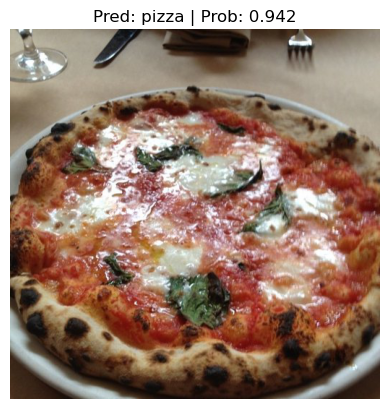

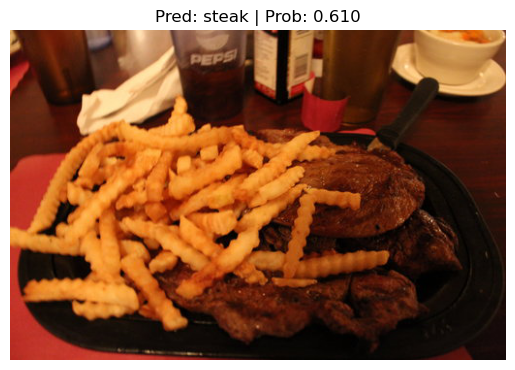

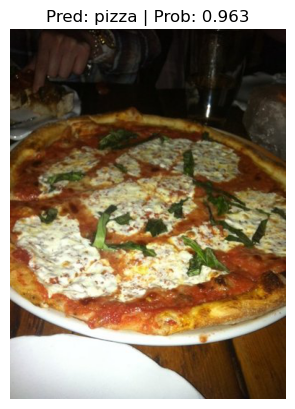

In [41]:
# Making and visualizing predictions
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k = num_images_to_plot)

# Iterate through random test image paths, make preds on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model = best_model, target_image_path=image_path, class_names=class_names, image_size = (224, 224))

#### 9.1 Predict on a custom image with the best model

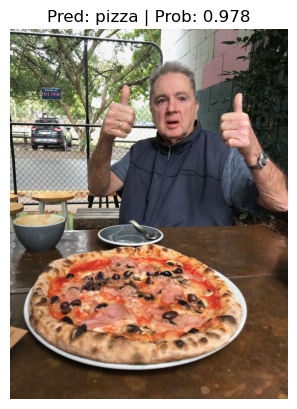

In [42]:
pred_and_plot_image(best_model, target_image_path="data/04-pizza-author.jpeg", class_names=class_names)